<a href="https://mingxia.web.unc.edu/" target="_parent"><img src="https://mingxia.web.unc.edu/wp-content/uploads/sites/12411/2020/12/logo_MagicLab-horizontal-4.png" alt="MAGIC Lab"/></a>

# **Denoiser Training on ADNI MRI**
---

**Loading required libraries**
---

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
import sys, argparse
import enum
import time
import datetime
import random
import json
import multiprocessing
import os.path as osp
#import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()
#import pylab as pl
#import logging
import shutil
import tempfile
import gzip
from typing import Optional, Sequence, Tuple, Union
from urllib.request import urlretrieve
#from PIL import Image

from pathlib import Path
from scipy import stats
from IPython import display
from tqdm import trange, tqdm

import math
import copy
import pprint
import torchio as tio
import torch
#import torchvision
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import L1Loss
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

#from torchvision.models.feature_extraction import get_graph_node_names
#from torchvision.models.feature_extraction import create_feature_extractor
import tensorboardX

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, roc_auc_score, matthews_corrcoef
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.manifold import TSNE
from sklearn import svm

#from neuroCombat import neuroCombat

import monai
import monai.transforms as mt
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset#, ImageDataset
#from monai.networks.nets import VarAutoEncoder,ViTAutoEnc, AutoEncoder
from monai.networks.layers.convutils import calculate_out_shape, same_padding
from monai.networks.layers.factories import Act, Norm
from monai.networks.utils import one_hot
from monai.utils import set_determinism, first
from monai.utils.enums import MetricReduction
from monai.metrics import compute_hausdorff_distance, HausdorffDistanceMetric
from monai.losses import DiceLoss#, DiceCELoss
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    Activations,
    #AddChannelD,
    Compose,
    LoadImageD,
    LoadImaged,
    ScaleIntensityD,
    #EnsureTypeD,
    #EnsureChannelFirstd,
    LoadImaged,
    Compose,
    CropForegroundd,
    CopyItemsd,
    SpatialPadd,
    #SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Orientationd,
    OneOf,
    ScaleIntensityRanged,
    RandSpatialCropSamplesd,
    #RandCoarseDropoutd,
    #RandCoarseShuffled,
    RandSpatialCrop,#(roi_size, max_roi_size=None, random_center=True, random_size=True, lazy=False)
    RandCropByPosNegLabeld,
    #Invertd,
)
#from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset#, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract

torch.manual_seed(0)
# Set Determinism
set_determinism(seed=0)

pin_memory = torch.cuda.is_available()
#pin_memory = False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

C:\Users\zhlt1\.conda\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


**Global Setting**
---

In [8]:
from metrics import psnr, ssim, batch_PSNR, batch_SSIM
pretrained_path = './pretrained/'
trained_path = './models/'
logdir_path = os.path.normpath('./log/')
if os.path.exists(logdir_path)==False:
    os.mkdir(logdir_path)
if os.path.exists(pretrained_path)==False:
    os.mkdir(pretrained_path)
if os.path.exists(trained_path)==False:
    os.mkdir(trained_path)

**File scanner**
---

In [9]:
class ScanFile(object):
    def __init__(self, directory, prefix=None, postfix=None):
        self.directory = directory
        self.prefix = prefix
        self.postfix = postfix

    def scan_files(self):
        files_list = []

        for dirpath, dirnames, filenames in os.walk(self.directory):
            ''''' 
            dirpath is a string, the path to the directory.   
            dirnames is a list of the names of the subdirectories in dirpath (excluding '.' and '..'). 
            filenames is a list of the names of the non-directory files in dirpath. 
            '''
            for special_file in filenames:
                if self.postfix:
                    if special_file.endswith(self.postfix):
                        files_list.append(os.path.join(dirpath, special_file))
                elif self.prefix:
                    if special_file.startswith(self.prefix):
                        files_list.append(os.path.join(dirpath, special_file))
                else:
                    files_list.append(os.path.join(dirpath, special_file))

        return files_list

    def scan_subdir(self):
        subdir_list = []
        for dirpath, dirnames, files in os.walk(self.directory):
            subdir_list.append(dirpath)
        return subdir_list

def torch_gradmap(img):
    #img=torch.nn.functional.pad(img, (1,0,1,0,1,0), "constant", 0) 
    dh = img[:,:,:,:,1:] - img[:,:,:,:,:-1]
    dw = img[:,:,:,1:,:] - img[:,:,:,:-1,:]
    dz = img[:,:,1:,:,:] - img[:,:,:-1,:,:]
    gra_map = (dh[:,:,1:, 1:, :] + dw[:,:,1:,:,1:] + dz[:,:,:,1:,1:])/3.
    gra_map=torch.nn.functional.pad(gra_map, (1,0,1,0,1,0), "constant", 0) 
    #gra_std = torch.std(gra_map, dim=(-1,-2,-3), keepdim=True)    
    return gra_map
def torch_std_estimate(img):
    dh = img[:,:,:,:,1:] - img[:,:,:,:,:-1]
    dw = img[:,:,:,1:,:] - img[:,:,:,:-1,:]
    dz = img[:,:,1:,:,:] - img[:,:,:-1,:,:]
    #gra_map = (dh[:,:,:-1, :-1, :] + dw[:,:,:-1,:,:-1] + dz[:,:,:,:-1,:-1])/3.
    gra_map = (dh[:,:,1:, 1:, :] + dw[:,:,1:,:,1:] + dz[:,:,:,1:,1:])/3.
    #gra_map=torch.nn.functional.pad(gra_map, (1,0,1,0,1,0), "constant", 0) 
    gra_std = torch.std(gra_map, dim=(-1,-2,-3), keepdim=True)   
    return gra_std
def torch_std_estimate_mask(img):
    dh = img[:,:,:,:,1:] - img[:,:,:,:,:-1]
    dw = img[:,:,:,1:,:] - img[:,:,:,:-1,:]
    dz = img[:,:,1:,:,:] - img[:,:,:-1,:,:]
    #gra_map = (dh[:,:,:-1, :-1, :] + dw[:,:,:-1,:,:-1] + dz[:,:,:,:-1,:-1])/3.
    gra_map = (dh[:,:,1:, 1:, :] + dw[:,:,1:,:,1:] + dz[:,:,:,1:,1:])/3.
    #gra_map=torch.nn.functional.pad(gra_map, (1,0,1,0,1,0), "constant", 0) 
    #gra_std = torch.std(gra_map, dim=(-1,-2,-3), keepdim=True)   
    mask = img>0
    mean = torch.mean(gra_map)
    gra_std = torch.sqrt(torch.sum((gra_map-mean)**2)/torch.sum(mask))
    return gra_std

**Preparing for data reading**
---

In [11]:
ADNI_dir = './SampleData/ADNI/'
#ADNI_dir = '../../../MICCAI2023project/data/ADNI_iBEAT_linearReg/'
scan1 = ScanFile(ADNI_dir, postfix='nii.gz')

mri_list  = sorted(scan1.scan_files())
filepath = mri_list[0]
print('filepath:'+filepath)
MRIf_first = nib.load(filepath)
vol_size  = (MRIf_first.header['dim'][1:4])
pix_space = (MRIf_first.header['pixdim'][1:4])
print('vol_size:'+str(vol_size))
print('pix_space:'+str(pix_space))

MRI_dict_list1 = []
for item in mri_list:
    MRI_dict_list1.append({'mristd':item})

MRI_list = MRI_dict_list1
test_number  =  int(len(MRI_list)*0.2)
train_number = int((len(MRI_list)-test_number)*1.0)
print('train_number:'+str(train_number))
print('test_number:'+str(test_number))
train_files = MRI_list[0:train_number]
test_files  = MRI_list[-test_number:]


filepath:./SampleData/ADNI/ADNI_0295.nii.gz
vol_size:[181 217 181]
pix_space:[1. 1. 1.]
train_number:8
test_number:2


**Define Dataset & DataLoader with Augamentation using MONAI**
---

In [12]:
train_transforms = Compose(
    [
        mt.LoadImaged(keys=['mristd'], ensure_channel_first=True, image_only=True),
        mt.ScaleIntensityRangePercentilesd(keys=['mristd'],lower=0, upper=98, b_min=0., b_max=1.0, clip=True),
        mt.CropForegroundd(keys=['mristd'], source_key="mristd", mode='empty'),
        mt.RandSpatialCropd(keys=['mristd'],roi_size=128, random_size=False),
        mt.RandFlipd(keys=['mristd'], prob=0.3, spatial_axis=None, lazy=False),
    ]
)

batchnum = 2
train_ds = Dataset(data=train_files, transform=train_transforms)
loader_train = DataLoader(train_ds, batch_size=batchnum, shuffle=True)

monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.3.


{'mristd': './SampleData/ADNI/ADNI_0295.nii.gz'}
check_data shape: torch.Size([2, 1, 128, 128, 128])
image shape: torch.Size([128, 128, 128])


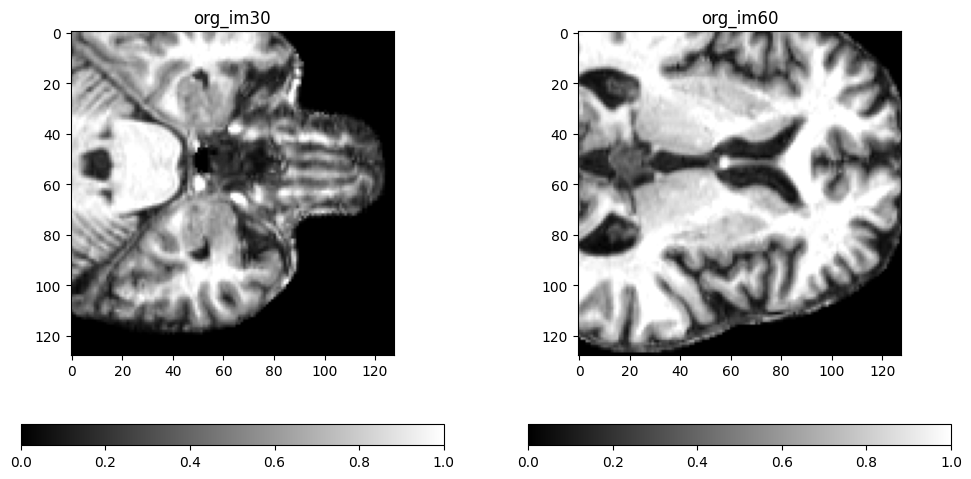

In [13]:
slicez = 30
print(train_files[0])
check_data = first(loader_train)
print(f"check_data shape: {check_data['mristd'].shape}")
image0 = check_data['mristd'][0][0]
print(f"image shape: {image0.shape}")

fig, axes = plt.subplots(1, 2, figsize=(2*6, 6))
im = axes[0].imshow(image0[:, :, slicez], cmap="gray")
cbar = fig.colorbar(im, ax=axes[0], orientation='horizontal')
axes[0].set_title('org_im'+str(slicez))
axes[0].grid(visible=False)

im = axes[1].imshow(image0[:, :, slicez+30], cmap="gray")
cbar = fig.colorbar(im, ax=axes[1], orientation='horizontal')
axes[1].set_title('org_im'+str(slicez+30))
axes[1].grid(visible=False)

plt.show()

**Model definition**
---

In [6]:
from models import AntiART_UNet, Denoiser_CondUNet
epoch_start = 0
MILESTONE = 5
NUM_EPOCHS = MILESTONE*3
LEARNING_RATE = 1e-4
LEARNING_RATE_DECAY = 0.1
OUT_DIR = logdir_path

scorenet = Denoiser_CondUNet(spatial_dims=3, in_channels=1, out_channels=1, features=(16, 32, 64, 128, 128, 16), norm='batch',upsample='nontrainable')
scorenet = scorenet.to(device)
optimizer = torch.optim.Adam(scorenet.parameters(), lr=LEARNING_RATE, weight_decay=0.000, betas=(0.9, 0.999), amsgrad=False)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, list(range(MILESTONE, NUM_EPOCHS, MILESTONE)), gamma = LEARNING_RATE_DECAY)

L1Loss   = torch.nn.L1Loss(reduction='mean')
MSELoss  = torch.nn.MSELoss(reduction='mean')

fSSIM   = monai.metrics.regression.SSIMMetric(spatial_dims=3, data_range=1.0)
fMSSSIM = monai.metrics.MultiScaleSSIMMetric(spatial_dims=3, data_range=1.0, kernel_size=7)
fPSNR   = monai.metrics.PSNRMetric(max_val=1.0, reduction=MetricReduction.MEAN, get_not_nans=False)
fRMSE   = monai.metrics.RMSEMetric(reduction=MetricReduction.MEAN, get_not_nans=False)


BasicUNet features: (16, 32, 64, 128, 128, 16).


**Training Function**
---

In [8]:
max_sigma = 1/3.
step = 1
print(str(epoch_start)+':'+str(NUM_EPOCHS))
for epoch in range(epoch_start, NUM_EPOCHS): 
    print(epoch)
    avg_loss = 0  
    with tqdm(total=len(loader_train), desc='Epoch: [%d/%d], lr: [%.6f]'%\
        (epoch+1, NUM_EPOCHS, optimizer.param_groups[0]["lr"]), miniters=1) as t:
        for i, (batch) in enumerate(loader_train):
            scorenet.train()
            scorenet.zero_grad()
            optimizer.zero_grad()

            samples = image_target = batch['mristd'].to(device).float()
            used_sigmas = torch.exp(torch.rand(samples.shape[0],1,1,1,1)*(math.log(max_sigma) - math.log(0.01)) + math.log(0.01))
            used_sigmas = used_sigmas.to(samples.device)
            noise = torch.randn_like(samples) * used_sigmas
            perturbed_samples = samples + noise
            
            est_sigmas = np.max([torch_std_estimate_mask(perturbed_samples).item(),0])
            est_sigmas = torch.tensor(est_sigmas,dtype=torch.float).to(device).view(1,1,1,1,1)
            print(perturbed_samples.shape)
            predict, de_x, _ = scorenet(perturbed_samples, est_sigmas)

            loss = L1Loss(predict,noise)

            denoised = perturbed_samples - predict*est_sigmas
            denoised = denoised.mean(1,keepdim=True)

            loss.backward()
            optimizer.step()

            avg_loss += loss.item()
            batch_psnr = 0
            with torch.no_grad():
                batch_psnr = batch_PSNR(denoised.as_tensor(), image_target.as_tensor())
                #batch_psnr = batch_PSNR(denoised, image_target)

            t.set_postfix_str("Batch Loss: %.4f, Batch PSNR: %.4f, average loss: %.4f" % (loss.item(),batch_psnr,  avg_loss/(i+1)))
            t.update()
            step += 1
            # break

        scheduler.step()
        if (epoch+1)%MILESTONE==0:
            checkpoint_path = os.path.join(f'./Pretrained_Denoiser_L1loss_adni_epoch%i.pth'% (epoch+1))
            chp = {
                'epoch': epoch, 
                'weights': scorenet.state_dict(),
                'optimizer': optimizer.state_dict()
                }
            torch.save(chp, checkpoint_path)
            print(checkpoint_path)


0:15
0


Epoch: [1/15], lr: [0.001000]:   0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([2, 1, 128, 128, 128])


Epoch: [1/15], lr: [0.001000]:  25%|██▌       | 1/4 [00:11<00:34, 11.45s/it, Batch Loss: 0.2984, Batch PSNR: 33.6098, average loss: 0.2984]

torch.Size([2, 1, 128, 128, 128])


Epoch: [1/15], lr: [0.001000]:  50%|█████     | 2/4 [00:19<00:19,  9.69s/it, Batch Loss: 0.2960, Batch PSNR: 23.1061, average loss: 0.2972]

torch.Size([2, 1, 128, 128, 128])


Epoch: [1/15], lr: [0.001000]:  50%|█████     | 2/4 [00:28<00:28, 14.24s/it, Batch Loss: 0.2960, Batch PSNR: 23.1061, average loss: 0.2972]


KeyboardInterrupt: 

**Test**
---

ADNI DATASET

In [9]:
'''
test_transforms = Compose(
    [
        mt.LoadImage(image_only=True, ensure_channel_first=True),
        mt.ScaleIntensityRangePercentiles(0, 98, 0.0, 1.0, True),
        mt.CropForeground(select_fn=threshold_at_one, margin=0),
        mt.DivisiblePad(k=16),
    ]
)
'''
test_transforms = Compose(
    [
        mt.LoadImaged(keys=['mristd'], ensure_channel_first=True, image_only=True),
        mt.ScaleIntensityRangePercentilesd(keys=['mristd'],lower=0, upper=98, b_min=0., b_max=1.0, clip=True),
        mt.CropForegroundd(keys=['mristd'], source_key="mristd", mode='empty'),
        mt.DivisiblePadd(keys=['mristd'], k=16),
    ]
)


test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_num=1, num_workers=1)
loader_test = DataLoader(test_ds, batch_size=1, num_workers=1)
print(test_files[0])

Loading dataset: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

{'mristd': './SampleData/ADNI/ADNI_0938.nii.gz'}


In [11]:
device='cpu'
if False:
    chp_path = './PretrainedModels/Denoiser_Unet_L1loss_adni_epoch15.pth'
    chp_path = './PretrainedModels/Pretrained_Denoiser_l1loss_epoch15.pth'
    scorenet = Denoiser_CondUNet(spatial_dims=3, in_channels=1, out_channels=1, features=(16, 32, 64, 128, 128, 16), norm='batch',upsample='nontrainable')
    
    states = torch.load(chp_path,map_location=torch.device(device))
    scorenet.load_state_dict(states['weights'])
    print("loaded model:"+chp_path)
scorenet = scorenet.to(device)
scorenet.eval();

sigmalist = [0.025,0.050,0.075,0.1,0.125, 0.15]
for sigma in sigmalist:
    psnr   = []
    rmse   = []
    ssim   = []
    msssim = []
    psnr1   = []
    rmse1   = []
    ssim1   = []
    msssim1 = []

    noise_sigma = torch.tensor(sigma)
    noise_sigma = noise_sigma.to(device).view(1,1,1,1,1)
    
    with tqdm(total=len(loader_test), desc='Test', miniters=1) as t:
        for i, (batch) in enumerate(loader_test):
            scorenet.eval()
            samples = image_target = batch['mristd'].to(device).float()
            img_grad = torch.abs(torch_gradmap(samples))

            mask = samples>0
            noise = torch.randn_like(samples)*noise_sigma.to(device) 
            perturbed_samples = (samples + noise)#.clip(0,1)* mask

            img_sigma = np.max([(torch_std_estimate(perturbed_samples).item()),0])
            img_sigma = torch.tensor(img_sigma,dtype=torch.float)
            img_sigma = img_sigma.to(device).view(1,1,1,1,1)

            predict, de_x, _ = scorenet(perturbed_samples, img_sigma)

            used_sigmas2 = img_sigma ** 2
            predict_noise = (predict*used_sigmas2)#.clip(-0.5,0.5)
            denoised = (perturbed_samples - predict_noise)#.clip(0,1)* mask
            
            batch_psnr   = fPSNR(  image_target, denoised)
            batch_rmse   = fRMSE(  image_target, denoised)
            batch_ssim   = fSSIM(  image_target, denoised)
            batch_msssim = fMSSSIM(image_target, denoised)
            psnr.append(torch.mean(batch_psnr).item())
            rmse.append(torch.mean(batch_rmse).item())
            ssim.append(torch.mean(batch_ssim).item())
            msssim.append(torch.mean(batch_msssim).item())

            if True:
                denoised_grad     = torch_gradmap(denoised)
                image_target_grad = torch_gradmap(image_target)
                batch_psnr   = fPSNR(  image_target_grad,denoised_grad)
                batch_rmse   = fRMSE(  image_target_grad,denoised_grad)
                batch_ssim   = fSSIM(  image_target_grad,denoised_grad)
                batch_msssim = fMSSSIM(image_target_grad,denoised_grad)
                psnr1.append(torch.mean(batch_psnr).item())
                rmse1.append(torch.mean(batch_rmse).item())
                ssim1.append(torch.mean(batch_ssim).item())
                msssim1.append(torch.mean(batch_msssim).item())

            t.set_postfix_str("PSNR: %.4f, RMSE: %.4f, SSIM: %.4f, MSSSIM: %.4f" % (psnr[-1], rmse[-1], ssim[-1], msssim[-1]))
            t.update()

            #break
            
    noise_std   = noise_sigma.squeeze().item()
    psnr_mean   = np.mean(psnr)
    psnr_std    = np.std(psnr)
    rmse_mean   = np.mean(rmse)
    rmse_std    = np.std(rmse)
    ssim_mean   = np.mean(ssim)
    ssim_std    = np.std(ssim)
    msssim_mean = np.mean(msssim)
    msssim_std  = np.std(msssim)

    psnr_mean1   = np.mean(psnr1)
    psnr_std1    = np.std(psnr1)
    rmse_mean1   = np.mean(rmse1)
    rmse_std1    = np.std(rmse1)
    ssim_mean1   = np.mean(ssim1)
    ssim_std1    = np.std(ssim1)
    msssim_mean1 = np.mean(msssim1)
    msssim_std1  = np.std(msssim1)

    print("Noise Std: %.3f, PSNR: %.2f\xB1%.2f, RMSE: %.4f\xB1%.4f, SSIM: %.4f\xB1%.4f, MSSSIM: %.4f\xB1%.4f" % (noise_std, psnr_mean, psnr_std, rmse_mean,rmse_std, ssim_mean,ssim_std, msssim_mean,msssim_std))
    print("Gradient map: \nNoise Std: %.3f, PSNR: %.2f\xB1%.2f, RMSE: %.4f\xB1%.4f, SSIM: %.4f\xB1%.4f, MSSSIM: %.4f\xB1%.4f" % (noise_std, psnr_mean1, psnr_std1, rmse_mean1,rmse_std1, ssim_mean1,ssim_std1, msssim_mean1,msssim_std1))
    
print('Test end!')


Test: 100%|██████████| 2/2 [01:10<00:00, 35.04s/it, PSNR: inf, RMSE: 0.0000, SSIM: 1.0000, MSSSIM: 1.0000]     
invalid value encountered in subtract


Noise Std: 0.000, PSNR: inf±nan, RMSE: 0.0000±0.0000, SSIM: 1.0000±0.0000, MSSSIM: 1.0000±0.0000
Gradient map: 
Noise Std: 0.000, PSNR: inf±nan, RMSE: 0.0000±0.0000, SSIM: 1.0000±0.0000, MSSSIM: 1.0000±0.0000


Test: 100%|██████████| 2/2 [01:40<00:00, 50.39s/it, PSNR: 32.0412, RMSE: 0.0250, SSIM: 0.7756, MSSSIM: 0.9782]


Noise Std: 0.025, PSNR: 32.04±0.00, RMSE: 0.0250±0.0000, SSIM: 0.7844±0.0088, MSSSIM: 0.9793±0.0010
Gradient map: 
Noise Std: 0.025, PSNR: 30.87±0.00, RMSE: 0.0286±0.0000, SSIM: 0.6604±0.0162, MSSSIM: 0.9733±0.0014


Test:   0%|          | 0/2 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000026932592D30>
Traceback (most recent call last):
  File "C:\Users\zhlt1\.conda\envs\torch\lib\site-packages\torch\utils\data\dataloader.py", line 1479, in __del__
KeyboardInterrupt: 
Test:   0%|          | 0/2 [00:29<?, ?it/s]


KeyboardInterrupt: 